Circuit context


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/helper_functions.py:1466: UserWarning: No backend selected. Training will be performed on Statevector simulator
  warnings.warn(


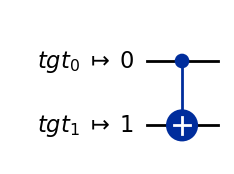

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from q_env_config import (
    get_circuit_context,
    apply_parametrized_circuit,
    custom_instruction_durations,
)
from rl_qoc import QuantumEnvironment, ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction
from rl_qoc.helpers import get_q_env_config
import os

config_file_name = "/q_env_gate_config.yml"
config_file_address = os.getcwd() + config_file_name
q_env_config = get_q_env_config(
    config_file_address,
    apply_parametrized_circuit,
)
q_env_config.parametrized_circuit_kwargs = {
    "target": q_env_config.target,
    "backend": q_env_config.backend,
}

default_num_qubits = 2
q_env_config.instruction_durations_dict = custom_instruction_durations(
    q_env_config.backend.num_qubits
    if q_env_config.backend is not None
    else default_num_qubits
)
circuit_context = get_circuit_context(
    q_env_config.backend, q_env_config.physical_qubits
)

circuit_context.draw("mpl")

In [3]:
from qiskit.visualization import plot_circuit_layout, plot_gate_map

if q_env_config.backend is not None and circuit_context.layout is not None:
    fig = plot_circuit_layout(
        circuit_context, q_env_config.backend_config.backend, view="physical"
    )
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
elif q_env_config.backend is not None and q_env_config.backend.coupling_map.size() != 0:
    fig = plot_gate_map(q_env_config.backend)
    print(
        "Selected backend:",
        q_env_config.backend.name,
        "backend version",
        q_env_config.backend_config.backend.version,
    )
else:
    fig = None
    print("No backend selected, cannot plot circuit layout or gate map")

fig

No backend selected, cannot plot circuit layout or gate map


In [5]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(q_env_config)
rescaled_env = ClipAction(RescaleAction(q_env, -1.0, 1.0))

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


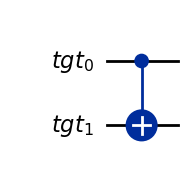

In [6]:
q_env.baseline_circuits[0].draw("mpl", style="iqp")

In [7]:
from rl_qoc.helpers import load_from_yaml_file
from pathlib import Path

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [8]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 2000
target_fidelities = [0.9]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=False,
)

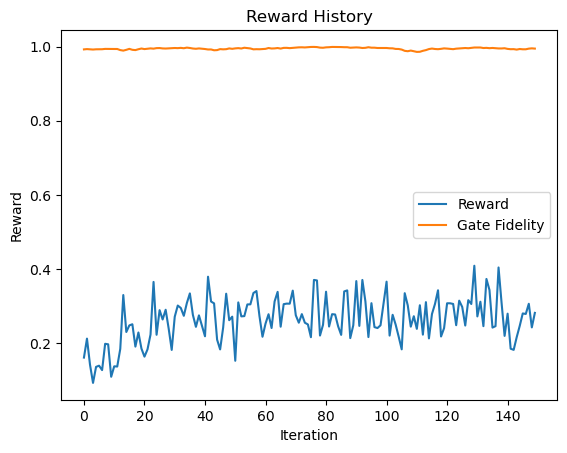

  8%|▊         | 150/2000 [02:33<31:43,  1.03s/it]

Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9946948348143714
Avg gate fidelity: 0.9946948348143714
Finished simulation benchmark
Hardware runtime taken: 49.02163199999999
Sending Estimator job...


  8%|▊         | 151/2000 [02:34<32:28,  1.05s/it]

Time for running 0.9720282554626465
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9952489016228505
Avg gate fidelity: 0.9952489016228505
Finished simulation benchmark
Hardware runtime taken: 49.36229759999999
Sending Estimator job...


  8%|▊         | 152/2000 [02:35<32:37,  1.06s/it]

Time for running 0.9409730434417725
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9955154185541328
Avg gate fidelity: 0.9955154185541328
Finished simulation benchmark
Hardware runtime taken: 49.69036159999999
Sending Estimator job...


  8%|▊         | 153/2000 [02:36<32:14,  1.05s/it]

Time for running 0.8929967880249023
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9954017634925082
Avg gate fidelity: 0.9954017634925082
Finished simulation benchmark
Hardware runtime taken: 50.02321279999999
Sending Estimator job...


  8%|▊         | 154/2000 [02:37<32:30,  1.06s/it]

Time for running 0.9494030475616455
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9950776292747147
Avg gate fidelity: 0.9950776292747147
Finished simulation benchmark
Hardware runtime taken: 50.35057279999999
Sending Estimator job...


  8%|▊         | 155/2000 [02:38<32:16,  1.05s/it]

Time for running 0.9074718952178955
Finished Estimator job
Starting simulation benchmark...
Starting simulation benchmark...
Fidelity stored 0.9951947334117008
Avg gate fidelity: 0.9951947334117008
Finished simulation benchmark
Hardware runtime taken: 50.65892479999999
Sending Estimator job...


  8%|▊         | 155/2000 [02:39<31:39,  1.03s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [9]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

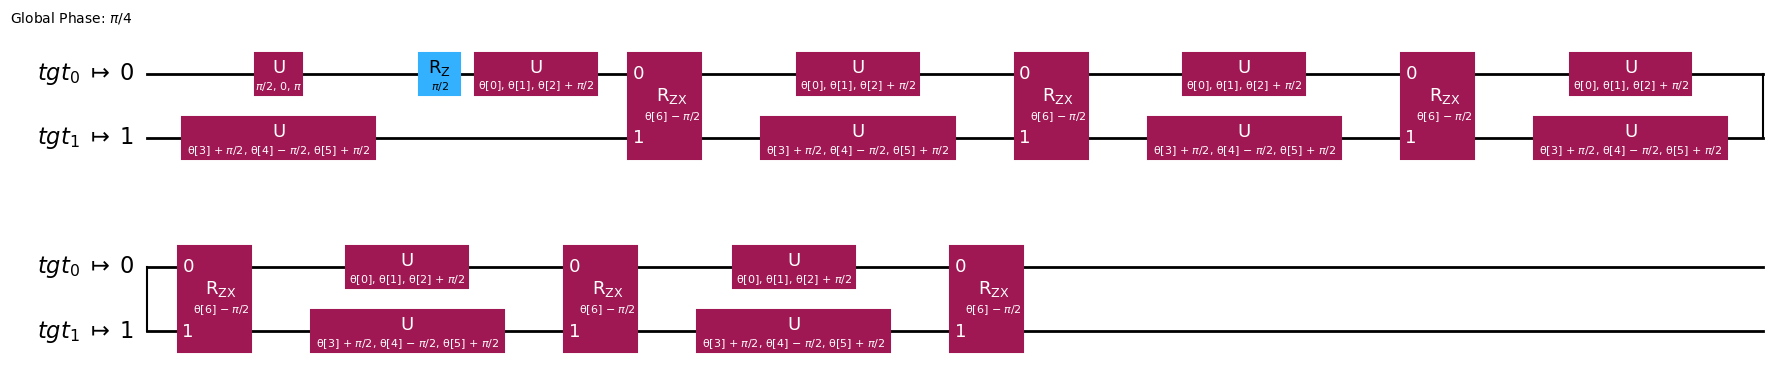

In [11]:
q_env._pubs[4][0].draw("mpl")

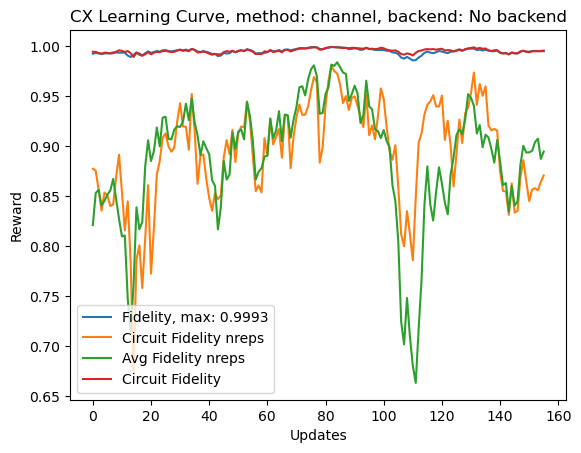

In [12]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

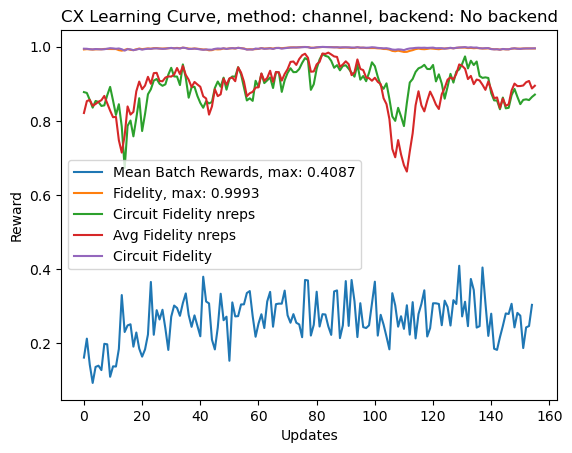

In [13]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

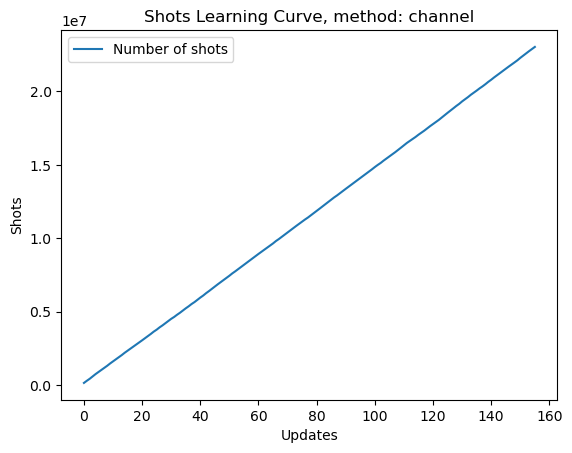

In [14]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, method: {q_env.config.reward_method}")
plt.legend()

In [15]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

Number of shots required for convergence: [ 151072  298656  436544  594272  752992  894496 1036576 1186624 1319488
 1475968 1619072 1765312 1904192 2046880 2203648 2343872 2479808 2615264
 2757344 2901376 3051712 3196704 3341632 3488544 3645312 3776832 3933664
 4068320 4219040 4367552 4515360 4641760 4791168 4926944 5077664 5230304
 5369184 5523040 5654208 5812032 5961504 6101312 6262880 6406592 6560224
 6716320 6865504 7010176 7158400 7304608 7449824 7608864 7747520 7896960
 8045728 8197120 8345888 8500160 8652128 8790784]


In [16]:
np.cumsum(q_env.hardware_runtime)

array([ 0.3323584,  0.6570432,  0.9603968,  1.3073984,  1.6565824,
        1.9678912,  2.2804672,  2.6105728,  2.9028736,  3.2471296,
        3.5619584,  3.8836864,  4.1892224,  4.503136 ,  4.8480256,
        5.1565184,  5.4555776,  5.7535808,  6.0661568,  6.3830272,
        6.7137664,  7.0327488,  7.3515904,  7.6747968,  8.0196864,
        8.3090304,  8.6540608,  8.950304 ,  9.281888 ,  9.6086144,
        9.933792 , 10.211872 , 10.5405696, 10.8392768, 11.1708608,
       11.5066688, 11.8122048, 12.150688 , 12.4392576, 12.7864704,
       13.1153088, 13.4228864, 13.778336 , 14.0945024, 14.4324928,
       14.775904 , 15.1041088, 15.4223872, 15.74848  , 16.0701376,
       16.3896128, 16.7395008, 17.044544 , 17.373312 , 17.7006016,
       18.033664 , 18.3609536, 18.700352 , 19.0346816, 19.3397248,
       19.6545536, 19.9662848, 20.2768192, 20.5852416, 20.8999296,
       21.2286272, 21.5849216, 21.8829248, 22.213664 , 22.5470784,
       22.8786624, 23.1931392, 23.5252864, 23.8555328, 24.1752

In [17]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit.quantum_info import Operator

print(
    "Fidelity of the final circuit:",
    q_env.target.gate_fidelity(
        q_env.circuits[0].assign_parameters(q_env.optimal_action).decompose()
    ),
)

Fidelity of the final circuit: 0.9976945714464932


In [18]:
q_env.mean_action

array([ 0.06219854, -0.20697463,  0.22336991, -0.03119394,  0.10654871,
        0.04338922,  0.07484066], dtype=float32)

In [19]:
q_env.optimal_action

array([ 0.05038877, -0.17842805,  0.20412986, -0.03584178,  0.06700793,
       -0.05188625,  0.00070569], dtype=float32)

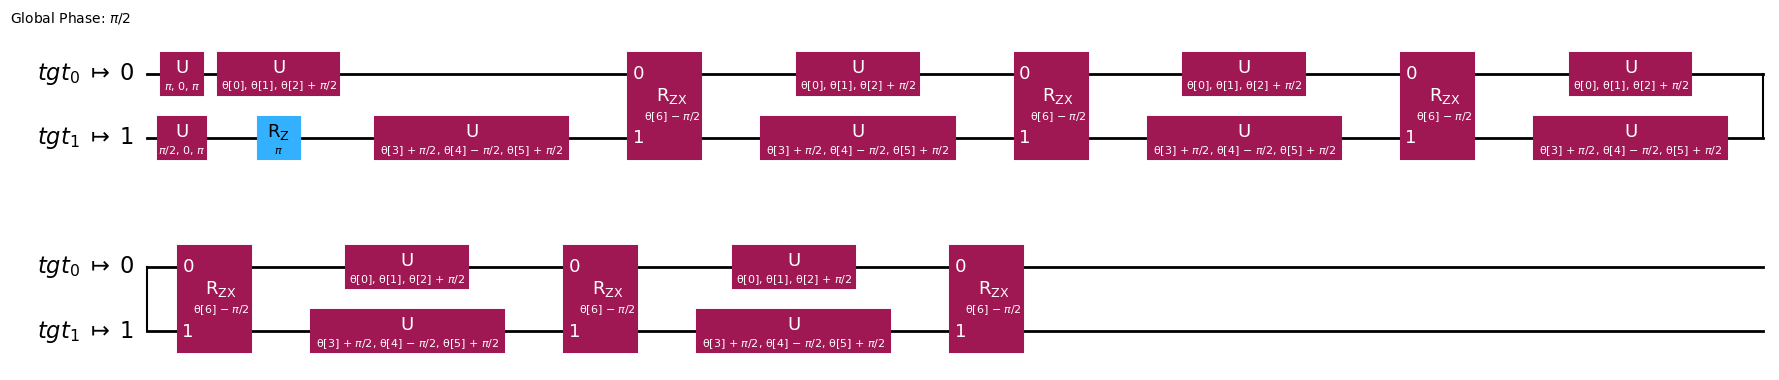

In [21]:
remove_unused_wires(q_env._pubs[8][0].remove_final_measurements(inplace=False)).draw(
    "mpl"
)

In [ ]:
q_env.std_action

In [ ]:
ppo_agent.training_results["std_action"]

In [ ]:
plt.plot(ppo_agent.training_results["std_action"])

In [ ]:
plt.plot(ppo_agent.training_results["mean_action"])

In [ ]:
from qiskit import transpile
from qiskit import QuantumCircuit

qc = QuantumCircuit(1)
qc.h(0)

transpiled_qc = transpile(qc, backend=q_env_config.backend, optimization_level=0)
transpiled_qc.draw("mpl")

In [ ]:
q_env.compute_benchmarks(
    q_env.circuits[0].copy(),
    np.array(
        [np.pi * np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0])] * q_env.batch_size
    ),
)

In [ ]:
q_env._pubs[34][0].draw("mpl")

In [ ]:
q_env._pubs[33][0].draw("mpl")

In [9]:
from qiskit import pulse
from qiskit_dynamics import Signal

with pulse.build() as sched:
    pulse.play(pulse.Constant(100, 0.5), pulse.DriveChannel(0))
    pulse.shift_phase(0.5, pulse.DriveChannel(0))
    pulse.play(pulse.Gaussian(100, 0.5, 10), pulse.DriveChannel(0))
signal = Signal(sched)

TypeError: unsupported operand type(s) for *: 'ScheduleBlock' and 'float'

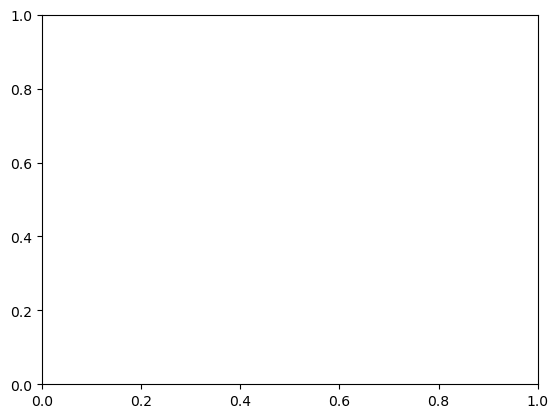

In [11]:
signal.draw(0, 100, 100)